In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyiron import Project
import pyiron_contrib
from copy import deepcopy

In [2]:
pr = Project('TI_Al_100K')

In [3]:
# structure
element = 'Al'
crystal_structure = 'fcc'
supercell = 3
potential = '1999--Mishin-Y--Al--LAMMPS--ipr1'

# MD specific
a = 4.039   
temperature = 100.
n_steps = 200000  # MD steps
sampling_period = 25  # same as `n_print` from calc_md
thermalization_steps = 1500  # number of steps to equilibriate the system for
temperature_damping_timescale = 100.  # same as the one from calc_md 
convergence_steps = 50000  # number of steps after which to check for convergence
fe_tol = 1e-3  # convergence criterion 1meV 

# integration specific
n_lambdas = 32

# cluster specific
phon_cores = 4
phon_run_time = 1800  # in seconds
tild_cores = n_lambdas  # if running on the headnode, use 1! Otherwise, set to n_lambdas
queue = 'cmti'
tild_run_time = 244000  # in seconds

In [4]:
# structures with the expanded lattice

pr_zero = pr.create_group('ionic_relaxation')

bulk = pr_zero.create_job(pr.job_type.Lammps, 'bulk')
bulk.structure = pr.create_ase_bulk(name=element, crystalstructure=crystal_structure, a=a,
                                    cubic=True).repeat(supercell)
n_atoms = len(bulk.structure.positions)
bulk.potential = potential
bulk.calc_minimize(pressure=None)  # we keep the volume constant! (because we obtained the lattice constant from MD)
bulk.run()
eq_energy = bulk.output.energy_pot[-1]

The job bulk was saved and received the ID: 15276120


In [5]:
bulk['output/generic/energy_pot']/108

array([-3.35972896, -3.35972896])

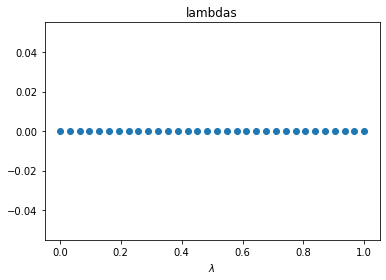

In [6]:
# generate and plot lambdas (integration_points)

def generate_lambdas(N, bias=0.5):
    """
    A function to generate N points between 0 and 1, with a left, equidistant and right bias.
    bias = 0 makes the points fully left biased. The amount of left bias can be controlled by varying it between 0 and 
        0.49.
    bias = 0.5 keeps the points equidistant.
    bias = 1 makes the points fully right biased. The amount of right bias can be controlled by varying it between 0.51 
        and 1.
    
    """
    factor = bias + 0.5
    lambdas = [0, 1]
    for n in np.arange(N - 2):
        lambdas.append(lambdas[-1] + (lambdas[-1] - lambdas[-2]) / factor)
    lambdas = np.asarray(lambdas)
    lambdas /= lambdas[-1]
    
    return np.around(lambdas, decimals=4)
# we use equidistant bias in new_generate_lambdas
lambdas = generate_lambdas(n_lambdas, bias=0.5)

plt.title('lambdas')
plt.scatter(lambdas, np.zeros(n_lambdas))
plt.xlabel('$\lambda$')
plt.show()

In [7]:
# setup phonopy job

pr_phon = pr.create_group('phonons')

phon_ref_job = pr_phon.create_job(pr.job_type.Lammps, 'phon_ref')
phon_ref_job.structure = bulk.get_structure()
phon_ref_job.potential = potential

for i in ['phonopy_job_normal', 'phonopy_job_hd' ]:
    phonopy_job = phon_ref_job.create_job(pr.job_type.PhonopyJob,i)
    phonopy_job.input['primitive_matrix'] = 'auto'
    if 'hd' in i:
        phonopy_job.input['displacement'] = 0.6
    phonopy_job.server.cores = phon_cores
    phonopy_job.server.queue = queue
    phonopy_job.server.run_time = phon_run_time
    phonopy_job.run()

The job phonopy_job_normal was saved and received the ID: 15276122
Queue system id:  2293378
The job phonopy_job_hd was saved and received the ID: 15276123
Queue system id:  2293379


Scaled distances:  [(0.0, 4.511458875459956), (4.511458875459956, 6.106500457335135), (6.106500457335135, 10.89162520296066), (10.89162520296066, 14.798663197130255), (14.798663197130255, 17.98874636101221), (17.98874636101221, 20.244475798556003)]
Scaled distances:  [(0.0, 3.2544612789477236), (3.2544612789477236, 4.405087098626742), (4.405087098626742, 7.8569645576637885), (7.8569645576637885, 10.675410700787763), (10.675410700787763, 12.97666234024073), (12.97666234024073, 14.603892979580284)]
A_h_quantum_normal: [0.03528166] eV/atom
A_h_quantum_anormal: [0.04860607] eV/atom
A_h_classical_normal: [0.02614905] eV/atom
A_h_classical_anormal: [0.03306531] eV/atom


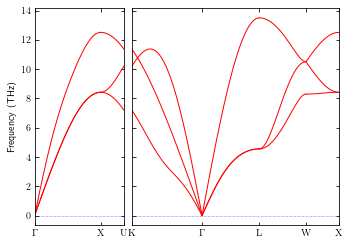

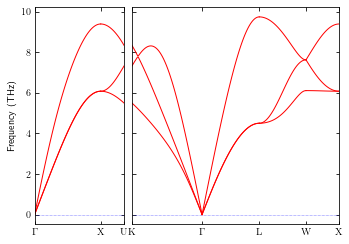

In [8]:
# load phonopy job  
pr_phonon = pr['phonons']
phonopy_job = pr_phonon.load('phonopy_job_normal')
phonopy_job_hd = pr_phonon.load('phonopy_job_hd')

phonopy_normal = phonopy_job.phonopy
phonopy_hd = phonopy_job_hd.phonopy
at_nu_prim = phonopy_normal.primitive.get_number_of_atoms()

# get force constants
force_constants_normal = phonopy_normal.force_constants
force_constants_hd = phonopy_hd.force_constants
force_constants_anormal = np.multiply(force_constants_hd,1.5)

# I call it anormal beacuse I have multiplied the force constants with 1.5
phonopy_anormal = deepcopy(phonopy_normal)
phonopy_anormal.set_force_constants(force_constants_anormal)

band_anormal_plot = phonopy_anormal.auto_band_structure(plot=True)
phonopy_anormal.run_mesh(mesh=[20,20,20])
phonopy_anormal.run_thermal_properties(temperatures=temperature,classic=True)
A_h_classical_anormal = phonopy_anormal.get_thermal_properties_dict()['free_energy']/at_nu_prim*0.01036410 #kjmol to ev
phonopy_anormal.run_thermal_properties(temperatures=temperature,classic=False)
A_h_quantum_anormal = phonopy_anormal.get_thermal_properties_dict()['free_energy']/at_nu_prim*0.01036410 #kjmol to ev

band_normal_plot = phonopy_normal.auto_band_structure(plot=True)
phonopy_normal.run_mesh(mesh=[20,20,20])
phonopy_normal.run_thermal_properties(temperatures=temperature,classic=True)
A_h_classical_normal = phonopy_normal.get_thermal_properties_dict()['free_energy']/at_nu_prim*0.01036410 #kjmol to ev
phonopy_normal.run_thermal_properties(temperatures=temperature,classic=False)
A_h_quantum_normal = phonopy_normal.get_thermal_properties_dict()['free_energy']/at_nu_prim*0.01036410 #kjmol to ev

print('A_h_quantum_normal: {} eV/atom'.format(A_h_quantum_normal  ))
print('A_h_quantum_anormal: {} eV/atom'.format(A_h_quantum_anormal  ))
print('A_h_classical_normal: {} eV/atom'.format(A_h_classical_normal  ))
print('A_h_classical_anormal: {} eV/atom'.format(A_h_classical_anormal  ))

band_anormal_plot.show()
band_normal_plot.show()

In [27]:
import pickle
with open('phonopy_normal100K.pickle', 'wb') as f:
    pickle.dump(phonopy_normal, f)
with open('phonopy_anormal100K.pickle', 'wb') as f:
    pickle.dump(phonopy_anormal, f)

## Not automatic create jobs one by one.
#### Change the name and the force constants

In [11]:
pr_tild = pr.create_group('tild_jobs_anormal') ######### NAME

# run the TILD protocol
tild_ref_job = pr_tild.create_job(pr.job_type.Lammps, 'ref_job')
tild_ref_job.potential = potential
tild_ref_job.structure = bulk.get_structure()
tild_ref_job.save()

job = pr_tild.create_job(pr.job_type.ProtoHarmTILDPar, 'job')
job.input.structure = bulk.get_structure()
job.input.temperature = temperature
job.input.ref_job_full_path = tild_ref_job.path
job.input.spring_constant = None
job.input.force_constants = force_constants_anormal ######### FORCE CONSTANTS
job.input.temperature_damping_timescale = temperature_damping_timescale
job.input.n_lambdas = n_lambdas
job.input.sampling_period = sampling_period
job.input.thermalization_steps = thermalization_steps
job.input.convergence_check_steps = convergence_steps
job.input.fe_tol = fe_tol
job.input.custom_lambdas = lambdas
job.input.n_steps = n_steps
job.input.eq_energy = eq_energy

# sleep-time, set this only if you're running this on your local PC
#job.input.sleep_time = 0.05

# cluster inputs
job.server.cores = tild_cores
job.server.queue = queue
job.server.run_time = tild_run_time

# run_job
job.run()

The job ref_job was saved and received the ID: 15276403
The job job was saved and received the ID: 15276405
Queue system id:  2293587


### Check results

In [12]:
pr = Project('TI_Al_100K')

In [13]:
pr['tild_jobs_normal/job/output']

{'groups': ['integrands', 'integrands_n_samples', 'integrands_std', 'temperature_mean', 'temperature_std', 'total_steps'], 'nodes': ['TYPE', 'fep_free_energy_mean', 'fep_free_energy_se', 'fep_free_energy_std', 'tild_free_energy_mean', 'tild_free_energy_se', 'tild_free_energy_std']}

In [14]:
pr['tild_jobs_anormal/job/output/integrands_n_samples/i_0']

array([1941, 1941, 1941, 1941, 1941, 1941, 1941, 1941, 1941, 1941, 1941,
       1941, 1941, 1941, 1941, 1941, 1941, 1941, 1941, 1941, 1941, 1941,
       1941, 1941, 1941, 1941, 1941, 1941, 1941, 1941, 1941, 1941])

### Integrand is different for different force constants

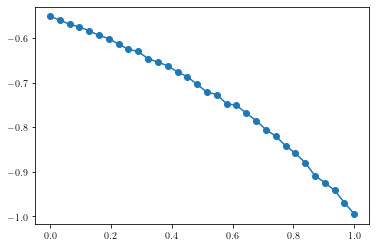

In [15]:
plt.plot(lambdas, pr['tild_jobs_anormal/job/output/integrands/i_0'], marker='o')

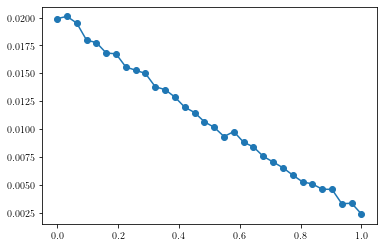

In [16]:
plt.plot(lambdas, pr['tild_jobs_normal/job/output/integrands/i_0'], marker='o')

In [28]:
with open('integrands_100K.npy', 'wb') as f:
    np.save(f, lambdas)
    np.save(f, pr['tild_jobs_normal/job/output/integrands/i_0'])
    np.save(f, pr['tild_jobs_anormal/job/output/integrands/i_0'])

# Classical harmonic oscillator model

In [18]:
n_atoms = 108 ###### 3*3*3 FCC Al

In [20]:
A_tild_normal = pr['tild_jobs_normal/job/output/tild_free_energy_mean'][-1] / n_atoms
A_tild_anormal = pr['tild_jobs_anormal/job/output/tild_free_energy_mean'][-1] / n_atoms

print('integral_uppercase: {} eV/atom'.format(A_tild_anormal)) 
print('A_harmonic_uppercase: {} eV/atom'.format(A_h_classical_anormal  )) # This is already per atom!!!
del_A_tild_anormal = A_h_classical_anormal + A_tild_anormal
print('total_A_uppercase: {} meV/atom'.format(del_A_tild_anormal*1000 ))
print('*-*-*-*-*-*-')
print('integral_lowercase: {} eV/atom'.format(A_tild_normal)) 
print('A_harmonic_lowercase: {} eV/atom'.format(A_h_classical_normal  )) # This is already per atom!!!
del_A_tild_normal = A_h_classical_normal + A_tild_normal
print('total_A_lowercase: {} meV/atom'.format(del_A_tild_normal*1000 ))

integral_uppercase: -0.006748681228625302 eV/atom
A_harmonic_uppercase: [0.03306531] eV/atom
total_A_uppercase: [26.31662822] meV/atom
*-*-*-*-*-*-
integral_lowercase: 0.00010156239357804293 eV/atom
A_harmonic_lowercase: [0.02614905] eV/atom
total_A_lowercase: [26.25061472] meV/atom


In [29]:
# FEP
A_feb_normal = pr['tild_jobs_normal/job/output/fep_free_energy_mean'][-1] / n_atoms
A_feb_anormal = pr['tild_jobs_anormal/job/output/fep_free_energy_mean'][-1] / n_atoms

print('integral_uppercase: {} eV/atom'.format(A_feb_anormal)) 
print('A_harmonic_uppercase: {} eV/atom'.format(A_h_classical_anormal  )) # This is already per atom!!!
del_A_feb_anormal = A_h_classical_anormal + A_feb_anormal
print('total_A_uppercase: {} meV/atom'.format(del_A_feb_anormal*1000 ))
print('*-*-*-*-*-*-')
print('integral_lowercase: {} eV/atom'.format(A_feb_normal)) 
print('A_harmonic_lowercase: {} eV/atom'.format(A_h_classical_normal  )) # This is already per atom!!!
del_A_feb_normal = A_h_classical_normal + A_feb_normal
print('total_A_lowercase: {} meV/atom'.format(del_A_feb_normal*1000 ))

integral_uppercase: -0.006814185790668853 eV/atom
A_harmonic_uppercase: [0.03306531] eV/atom
total_A_uppercase: [26.25112365] meV/atom
*-*-*-*-*-*-
integral_lowercase: 9.895544953728583e-05 eV/atom
A_harmonic_lowercase: [0.02614905] eV/atom
total_A_lowercase: [26.24800778] meV/atom


# Quantum harmonic oscillator model

In [21]:
A_tild_normal = pr['tild_jobs_normal/job/output/tild_free_energy_mean'][-1] / n_atoms
A_tild_anormal = pr['tild_jobs_anormal/job/output/tild_free_energy_mean'][-1] / n_atoms

print('integral_uppercase: {} eV/atom'.format(A_tild_anormal)) 
print('A_harmonic_uppercase: {} eV/atom'.format(A_h_quantum_anormal  )) # This is already per atom!!!
del_A_tild_anormal = A_h_quantum_anormal + A_tild_anormal
print('total_A_uppercase: {} meV/atom'.format(del_A_tild_anormal*1000 ))
print('*-*-*-*-*-*-')
print('integral_lowercase: {} eV/atom'.format(A_tild_normal)) 
print('A_harmonic_lowercase: {} eV/atom'.format(A_h_quantum_normal  )) # This is already per atom!!!
del_A_tild_normal = A_h_quantum_normal + A_tild_normal
print('total_A_lowercase: {} meV/atom'.format(del_A_tild_normal*1000 ))

integral_uppercase: -0.006748681228625302 eV/atom
A_harmonic_uppercase: [0.04860607] eV/atom
total_A_uppercase: [41.85739276] meV/atom
*-*-*-*-*-*-
integral_lowercase: 0.00010156239357804293 eV/atom
A_harmonic_lowercase: [0.03528166] eV/atom
total_A_lowercase: [35.38322453] meV/atom


In [31]:
#FEP
A_tild_normal = pr['tild_jobs_normal/job/output/fep_free_energy_mean'][-1] / n_atoms
A_tild_anormal = pr['tild_jobs_anormal/job/output/fep_free_energy_mean'][-1] / n_atoms

print('integral_uppercase: {} eV/atom'.format(A_fep_anormal)) 
print('A_harmonic_uppercase: {} eV/atom'.format(A_h_quantum_anormal  )) # This is already per atom!!!
del_A_fep_anormal = A_h_quantum_anormal + A_fep_anormal
print('total_A_uppercase: {} meV/atom'.format(del_A_fep_anormal*1000 ))
print('*-*-*-*-*-*-')
print('integral_lowercase: {} eV/atom'.format(A_fep_normal)) 
print('A_harmonic_lowercase: {} eV/atom'.format(A_h_quantum_normal  )) # This is already per atom!!!
del_A_fep_normal = A_h_quantum_normal + A_fep_normal
print('total_A_lowercase: {} meV/atom'.format(del_A_fep_normal*1000 ))

integral_uppercase: -0.006814185790668853 eV/atom
A_harmonic_uppercase: [0.04860607] eV/atom
total_A_uppercase: [41.7918882] meV/atom
*-*-*-*-*-*-
integral_lowercase: 9.895544953728583e-05 eV/atom
A_harmonic_lowercase: [0.03528166] eV/atom
total_A_lowercase: [35.38061759] meV/atom


# Some figures for fcc aluminum classical versus Qm free energies

In [22]:
temperatures = np.linspace(10,900,num=200)
phonopy_instance = deepcopy(phonopy_normal)

at_nu_prim = phonopy_instance.primitive.get_number_of_atoms()


phonopy_instance.run_thermal_properties(temperatures=temperatures,classic=True)
classical_free_en = phonopy_instance.get_thermal_properties_dict()['free_energy']/at_nu_prim*0.01036410 #kjmol to ev
classical_cv = phonopy_instance.get_thermal_properties_dict()['heat_capacity']/at_nu_prim*3

phonopy_instance.run_thermal_properties(temperatures=temperatures,classic=False)
quantum_free_en = phonopy_instance.get_thermal_properties_dict()['free_energy']/at_nu_prim*0.01036410 #kjmol to ev
quantum_cv = phonopy_instance.get_thermal_properties_dict()['heat_capacity']/at_nu_prim

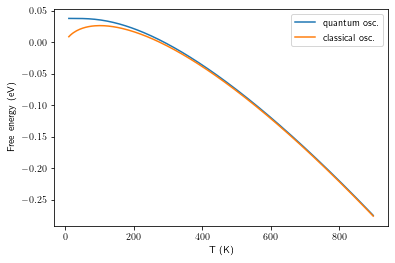

In [24]:
plt.figure()
plt.plot(temperatures, quantum_free_en,label = 'quantum osc.')
plt.plot(temperatures, classical_free_en,label = 'classical osc.')
plt.ylabel('Free energy (eV)')
plt.xlabel("T (K)")
plt.legend()
plt.show()

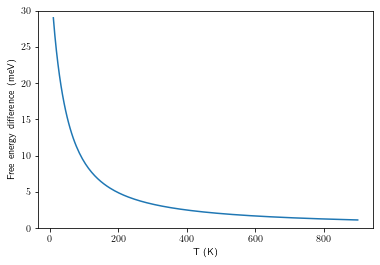

In [25]:
free_en_diff = (quantum_free_en - classical_free_en)*1000
plt.figure()
plt.plot(temperatures,free_en_diff,label='Classical oscillator')
plt.ylabel('Free energy difference (meV)')
plt.xlabel("T (K)")
plt.ylim([0,30])
plt.show()

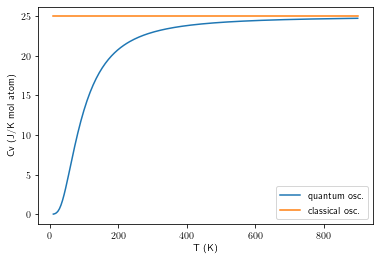

In [26]:
plt.figure()
plt.plot(temperatures, quantum_cv,label = 'quantum osc.')
plt.plot(temperatures, classical_cv,label = 'classical osc.')
plt.ylabel('Cv (J/K mol atom)')
plt.xlabel("T (K)")
plt.legend()
plt.show()

In [ ]:
with open('Al_qm_cm_results.npy', 'wb') as f:
    np.save(f, temperatures)
    np.save(f, quantum_free_en)
    np.save(f, classical_free_en)
    np.save(f, quantum_cv)
    np.save(f, classical_cv)

## Notebook ends here.